[0, 1, 2, 3]


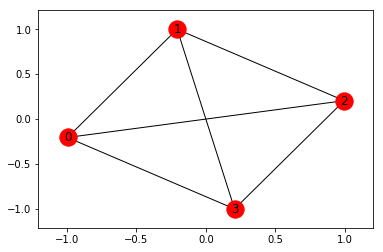

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from pyquil.api import get_qc

ideal_qc = get_qc("4q-qvm", as_qvm=True, noisy=False)
noisy_qc = get_qc("4q-noisy-qvm", as_qvm=True, noisy=True)

qubits = ideal_qc.qubits()
print(qubits)
graph = ideal_qc.qubit_topology()
nx.draw_networkx(graph, with_labels=True)

# Replicate FIG2. of [QVol]  (See forest_qcvv.quantum_volume for ref) SLOW

In [2]:
from forest_qcvv.quantum_volume import measure_quantum_volume
ideal_outcomes = measure_quantum_volume(ideal_qc, num_circuits=200)

# SLOW

In [3]:
noisy_outcomes = measure_quantum_volume(noisy_qc, num_circuits=200, num_shots=500)

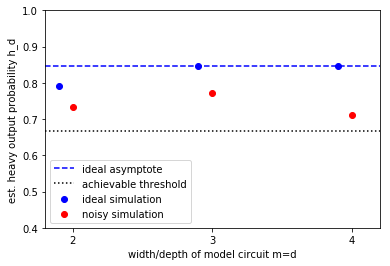

In [4]:
depths = np.arange(2, 5)
ideal_probs = [val[1] for val in ideal_outcomes]
noisy_probs = [val[1] for val in noisy_outcomes]

xlims = (1.8, 4.2)
plt.plot(xlims, [.5+np.log(2)/2]*2, color='b', ls='--')
plt.plot(xlims, [2/3]*2, color='black', ls=':')
plt.scatter(np.array(depths)-.1, ideal_probs, color='b')
plt.scatter(depths, noisy_probs, color='r')
plt.ylabel("est. heavy output probability h_d")
plt.xlabel("width/depth of model circuit m=d")
plt.ylim(.4,1.0)
plt.xlim(*xlims)
plt.xticks(depths)
plt.legend(['ideal asymptote', 'achievable threshold', 'ideal simulation', 'noisy simulation'], loc=3)
plt.show()